In [222]:
# Manejo y visualización de datos.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Etiquetado 
from sklearn.preprocessing import LabelEncoder
# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
# Train,test split
from sklearn.model_selection import train_test_split
# Metricas
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import classification_report
# Selección de variables y tuneo de hiperparametros
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
# Balanceo
from imblearn.over_sampling import SMOTE
# Validacion cruzaada
from sklearn.model_selection import cross_val_score
# Ignorar warning
import warnings
warnings.filterwarnings("ignore")

### <b> Importamos Datos </b>

In [223]:
# Importamos las etiquetas y creamos la target en numericas, Siendo 1 funciona, 0 no funciona y 2 necesita reparación.
X_train_labels = pd.read_csv('./Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')
X_train_labels["target"] = X_train_labels["status_group"].map({"functional":1,"non functional":0,"functional needs repair":2})
y_train= X_train_labels.target
print(f"La Var Objetivo de entrenamiento tiene {y_train.shape[0]} filas")

# importamos el conjunto con los valores de entrenamiento: 
X_train = pd.read_csv('./Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')
print(f"El conjunto de entrenamiento tiene {X_train.shape[0]} filas y {X_train.shape[1]} columnas")

# Importamos el test -- *
x_test = pd.read_csv('./Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv')
print(f"El test tiene {x_test.shape[0]} filas y {x_test.shape[1]} columnas")


La Var Objetivo de entrenamiento tiene 59400 filas
El conjunto de entrenamiento tiene 59400 filas y 40 columnas
El test tiene 14850 filas y 40 columnas


### Unimos los datos para realizar las transformaciones una sola vez

In [224]:
# Creamos una columna con un identificador y unimos train y test
x_test["Conjunto"] = "test"
X_train["Conjunto"] = "train"
dt = pd.concat([X_train,x_test],axis=0)
print(f"{dt.shape}")
dt = dt.join(y_train)
dt.head()


(74250, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Conjunto,target
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,train,1
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,test,1
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train,1
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,test,1
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,train,1


### Preprocesado de los datos

In [225]:
# Vemos si hay valores nulos
#Proporción de missings por variable 
dt.apply(lambda x: x.isna().sum()/x.count()*100)

id                        0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    6.457718
gps_height                0.000000
installer                 6.500473
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
subvillage                0.637029
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.927670
recorded_by               0.000000
scheme_management         6.982306
scheme_name              90.423677
permit                    5.383425
construction_year         0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

In [226]:
# quitamos la variable scheme_name por tener un 90.4% de valores missing
dt.drop(columns={"scheme_name"},axis=1,inplace=True)

In [227]:
dt.describe(include='all')

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Conjunto,target
count,74250.000000,74250.000000,74250,69746,74250.000000,69718,74250.000000,7.425000e+04,74250,74250.000000,...,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250.000000
unique,NaN,NaN,369,2140,NaN,2410,NaN,NaN,45684,NaN,...,6,5,5,10,7,3,7,6,2,NaN
top,NaN,NaN,2011-03-17,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,train,NaN
freq,NaN,NaN,695,11299,NaN,21751,NaN,NaN,4440,NaN,...,63505,41522,41522,21216,21216,57286,35628,43239,59400,NaN
mean,37124.500000,318.685704,NaN,NaN,665.667313,NaN,34.074262,-5.701771e+00,NaN,0.462330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.688377
std,21434.273081,2906.762364,NaN,NaN,692.761033,NaN,6.572519,2.944969e+00,NaN,11.537879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.599843
min,0.000000,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,18562.250000,0.000000,NaN,NaN,0.000000,NaN,33.086819,-8.525675e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,37124.500000,0.000000,NaN,NaN,364.000000,NaN,34.907475,-5.026540e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,55686.750000,20.000000,NaN,NaN,1317.000000,NaN,37.181685,-3.325058e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [228]:
# vemos si hay variables con valores unicos para quitarlos, ya que no nos aportan información
for j in dt.columns:
    a=dt[j].nunique()
    if a <2:
        print(f"La variable {j} del conjunto de datos se elimina por tener un solo valor")
        dt.drop(columns=[j],axis=1,inplace=True)

La variable recorded_by del conjunto de datos se elimina por tener un solo valor


In [229]:
# Pasamos a datetime la variable date_recorded
dt["date_recorded"] = pd.to_datetime(dt["date_recorded"])

In [230]:
# generamos las listas con las variables categoricas.
lista_categoricas = list(dt.select_dtypes(include='object'))

# generamos las listas con las variables numericas
lista_numericas = dt.select_dtypes(include=['int','float'])

### <b> Pintamos las variables numericas para observar las distribuciones de cada una.</b>
* Variable: Population,amount_tsh y num_private aportan poco o nada ya que carecen de información que nos pueda decir si una bombda esta rota o funcionando al ser solo un numero. Se intentó mejorar el modelo quitandolas pero algun tipo de efecto tendrá en arbol que mejora levemente la puntuación si nos quedamos con ellas. 

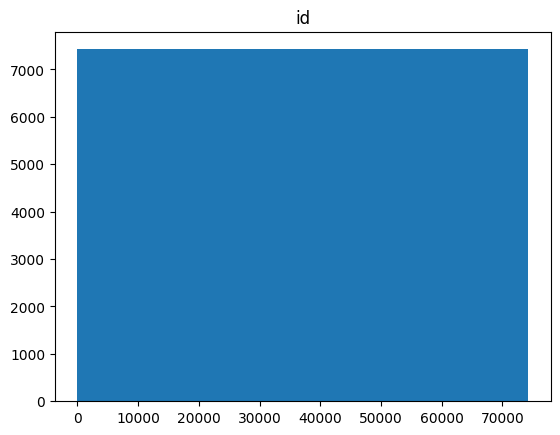

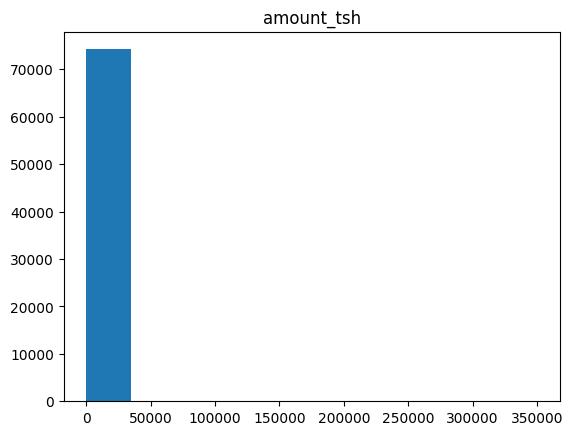

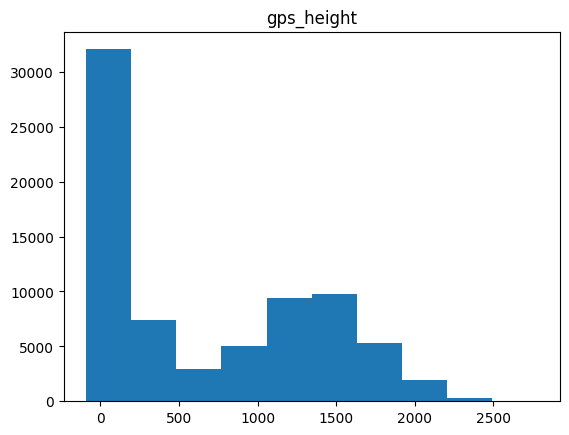

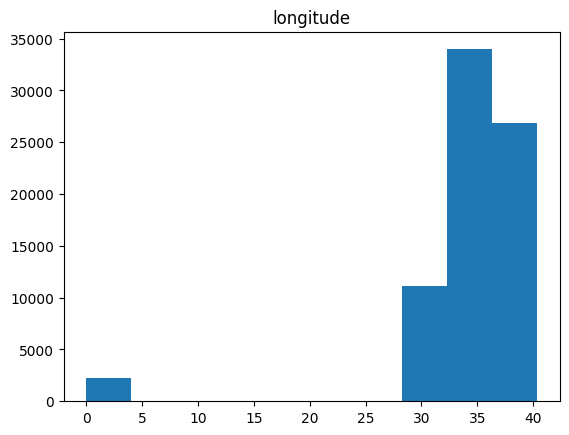

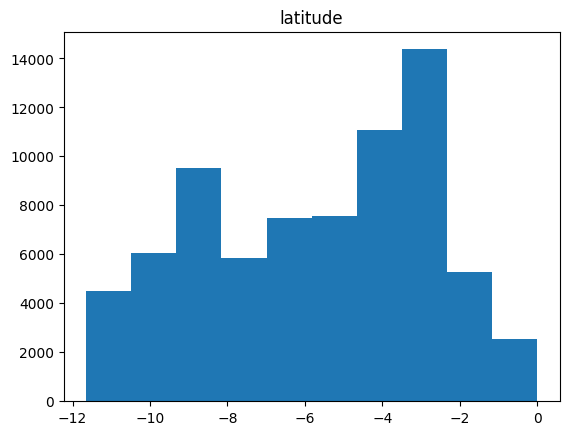

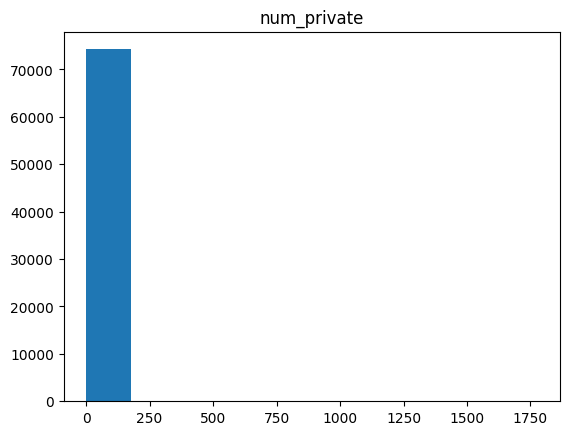

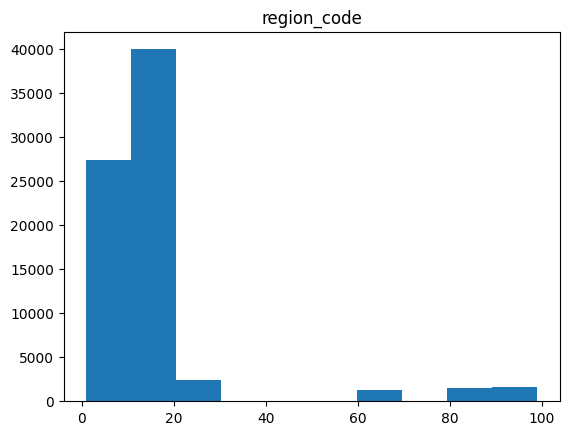

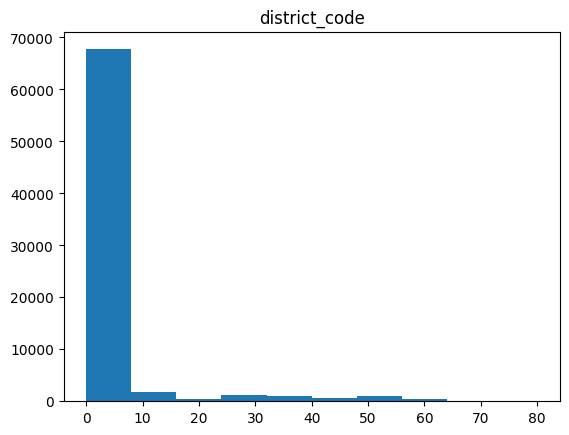

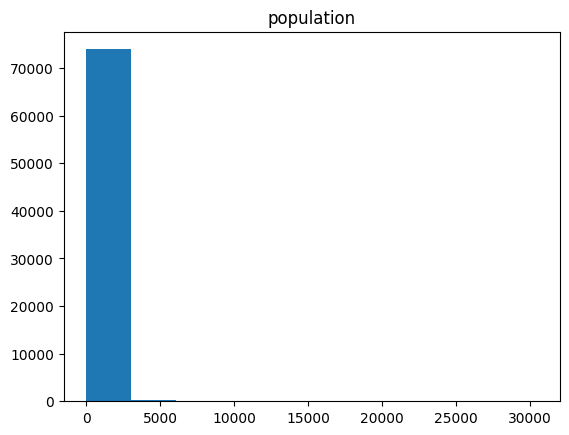

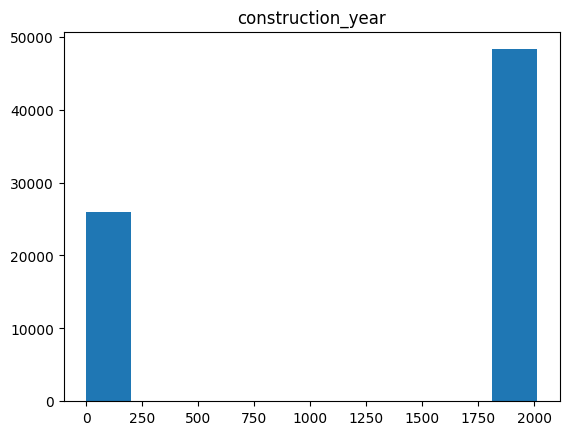

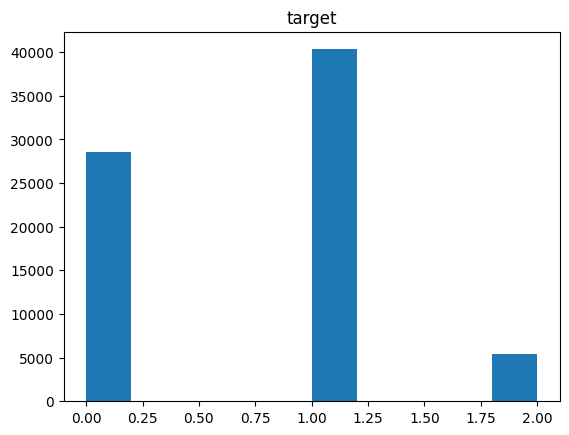

In [231]:
for l in lista_numericas:
    plt.hist(dt[l])
    plt.title(l)
    plt.show()

## <b> Preprocesado del conjunto de datos (dt)</b>:
* Quitamos el id por ser el identificador de la bomba, luego lo añadiremos.
* Creamos las variables: año, mes y día. Eliminamos la general ya que tenemos esos datos en las otras variables recien creadas.
* Creamos un bucle con Label encoder para ordenar alfabeticamente los valores de las variables categoricas e imputarles un numero de 0 a n. 

Tiraremos un primer modelo y comparamos la respuesta de la variable contra la target para ver donde mejorar y poder realizar tramificaciones

In [232]:
conjunto = dt.Conjunto

In [233]:
# Preprocesado+
dt.drop(columns='id',inplace=True)

# Creamos columnas de año, mes, dia y eliminamos la variable date_recorder
dt["year"] = dt["date_recorded"].dt.year 
dt["month"] = dt["date_recorded"].dt.month
dt["day"] = dt["date_recorded"].dt.day

dt.drop(columns='date_recorded',inplace=True)


In [234]:
for i in dt[lista_categoricas]:
    le=LabelEncoder()
    le.fit(dt[i].unique())
    dt[i]=le.transform(dt[i])

In [235]:
dt.drop(columns='Conjunto',inplace=True)

In [236]:
dt.shape

(74250, 40)

Las variables que más correlación tienen contra la target son el tipo de extracción, grupo y tipo de waterpoint. 

In [237]:
corr = abs(dt.corr())
corr[['target']].sort_values(by = 'target',ascending = False).style.background_gradient()

,target
target,1.000000
extraction_type_class,0.156309
waterpoint_type_group,0.155481
waterpoint_type,0.152779
quality_group,0.121763
quantity,0.119926
quantity_group,0.119926
extraction_type_group,0.107734
extraction_type,0.099196
source,0.079758


In [238]:
dt = pd.concat([dt,conjunto],axis=1)

In [239]:
water = dt[dt["Conjunto"]=="train"]
test_water = dt[dt["Conjunto"]=="test"]
water.drop("Conjunto",axis=1,inplace=True);
water.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,target,year,month,day
0,6000.0,1548,1390,1706,34.938093,-9.856322,45683,0,1,13116,...,1,8,6,0,1,1,1,2011,3,14
1,0.0,522,1399,610,34.698766,-2.147466,45426,0,4,17596,...,2,5,3,1,1,1,1,2013,3,6
2,25.0,924,686,2296,37.460664,-3.821329,17767,0,5,10096,...,1,0,1,1,2,1,1,2013,2,25
3,0.0,1961,263,2078,38.486161,-11.155298,45537,0,7,9998,...,0,3,0,0,2,1,0,2013,1,28
4,0.0,20,0,133,31.130847,-1.825359,43411,0,4,8583,...,3,5,3,1,1,1,1,2011,7,13


In [240]:
test_water.drop(columns={"target","Conjunto"},inplace=True)

### División Train y Test:
* Generamos la división en train y test para poder ver los scores antes de mandar la predicción. 
* Una vez elegido el modelo ganador, entrenamos con el conjunto de datos total nuestro modelo y enviamos esa predicción.

In [241]:

X_train, X_test, y_train, y_test = train_test_split(water.drop('target',axis=1),
                                                    water.target,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = water.target)



## Modelo RandomForest

In [242]:
model1 = RandomForestClassifier().fit(X_train,y_train)
y_pred1 = model1.predict(X_test)

In [243]:
def saca_metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)  

In [244]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      4565
           1       0.82      0.89      0.85      6452
           2       0.55      0.35      0.42       863

    accuracy                           0.82     11880
   macro avg       0.74      0.68      0.70     11880
weighted avg       0.81      0.82      0.81     11880



In [246]:
resultado = model1.predict(test_water)
prediccion = pd.DataFrame(resultado,columns=["Predicciones"])
prediccion["status_group"] = prediccion["Predicciones"].map({1:"functional",0:"non functional",2:"functional needs repair"})


In [247]:
prediccion=prediccion.join(x_test.id)
entrega=prediccion.loc[:,['id','status_group']]
entrega= entrega.sort_index()
entrega["status_group"] = entrega["status_group"].astype('str')
entrega["id"] = entrega["id"].astype('str')
entrega["id,status_group"]=(entrega.id )+","+(entrega.status_group)

In [248]:
entrega.drop(columns={"status_group","id"},inplace=True)
entrega=entrega.set_index("id,status_group")
entrega.to_csv('entrega.csv',sep=";")

## Segundo Modelo XGB Classifier

In [249]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


In [250]:
model2 = XGBClassifier(random_state=42)
model2.fit(X_train, y_train)

# Realizamo predicciones en el conjunto de prueba
y_pred = model2.predict(X_test)

# Evaluamos las métricas de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      4565
           1       0.79      0.91      0.84      6452
           2       0.66      0.26      0.38       863

    accuracy                           0.80     11880
   macro avg       0.76      0.64      0.67     11880
weighted avg       0.80      0.80      0.79     11880



La puntuación obetenida con el XGB es inferior al RF de forma general ni en f1 ni en accuracy mejora el modelo anterior

In [251]:
resultado2 = model2.predict(test_water)
prediccion2 = pd.DataFrame(resultado2,columns=["Predicciones"])
prediccion2["status_group"] = prediccion2["Predicciones"].map({1:"functional",0:"non functional",2:"functional needs repair"})
prediccion2=prediccion2.join(x_test.id)
entrega2=prediccion2.loc[:,['id','status_group']]
entrega2= entrega2.sort_index()
entrega2["status_group"] = entrega2["status_group"].astype('str')
entrega2["id"] = entrega2["id"].astype('str')
entrega2["id,status_group"]=(entrega2.id )+","+(entrega2.status_group)
entrega2.drop(columns={"status_group","id"},inplace=True)
entrega2=entrega2.set_index("id,status_group")
entrega2.to_csv('entrega2.csv',sep=";")


## Mejora de Modelos:

De las pruebas realizadas, RandomForest acierta mejor que el XGB Classifier. Vamos a realizar una mejora del modelo con un oversampling para la target que menos valores tiene para comprobar si conseguimos subir el score.

In [252]:
# oversampling
sm = SMOTE(random_state=2,sampling_strategy='auto')
x_water_sam, y_water_sam = sm.fit_resample(water.drop('target',axis=1), water.target.ravel())

In [253]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(x_water_sam,
                                                    y_water_sam,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y_water_sam)

In [254]:
modelBalanceo = RandomForestClassifier().fit(X_train_res,y_train_res)
y_pred_res = modelBalanceo.predict(X_test_res)

In [276]:
# Pintamos resultados
print(classification_report(y_test_res, y_pred_res))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      6452
           1       0.83      0.87      0.85      6452
           2       0.88      0.92      0.90      6452

    accuracy                           0.86     19356
   macro avg       0.86      0.86      0.86     19356
weighted avg       0.86      0.86      0.86     19356



El modelo balanceado tiene mejor puntuación con los datos de entrenamiento pero no mejora la puntuación obtenida en la competición por el RF.

### <b>TERCERA ENTREGA: MODELO CON BALANCEO</b>

In [256]:
resultado3 = modelBalanceo.predict(test_water)
prediccion3 = pd.DataFrame(resultado3,columns=["Predicciones"])
prediccion3["status_group"] = prediccion3["Predicciones"].map({1:"functional",0:"non functional",2:"functional needs repair"})

In [257]:
prediccion3=prediccion3.join(x_test.id)
entrega3=prediccion3.loc[:,['id','status_group']]
entrega3= entrega3.sort_index()
entrega3["status_group"] = entrega3["status_group"].astype('str')
entrega3["id"] = entrega3["id"].astype('str')
entrega3["id,status_group"]=(entrega3.id )+","+(entrega3.status_group)

In [258]:
entrega3.drop(columns={"status_group","id"},inplace=True)
entrega3=entrega3.set_index("id,status_group")
entrega3.to_csv('entrega3.csv',sep=";")

No mejora en competicion la puntuacion con un oversampling, aunque con los datos de entrenamiento como era de esperar si mejorase el F1

-------------------------------------------------------------------------------------------------------------------------------------------

Veamos las variables mas importantes para nuestro modelo  y como reaccionan respecto a la target

<Axes: >

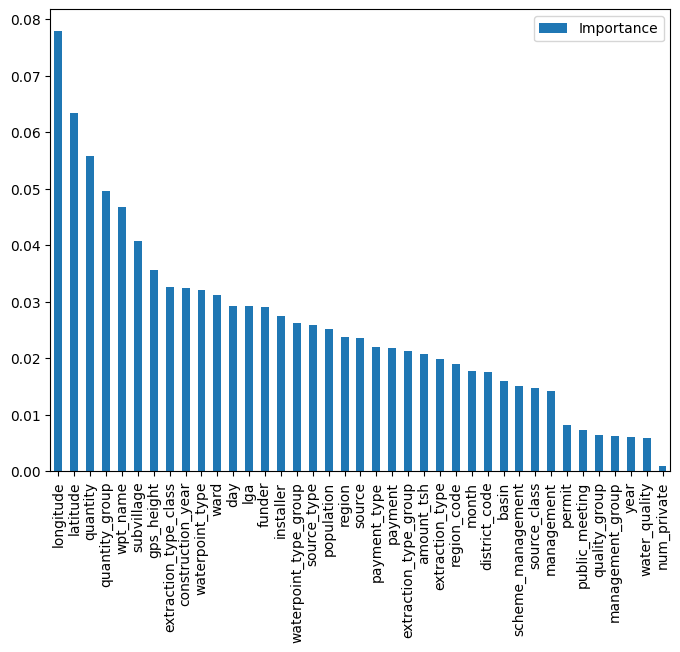

In [259]:
feat_importances = pd.DataFrame(modelBalanceo.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

Vemos que las 5 primeras variables son las que mas importancia tienen en nuestro modelo

### <b> Estudio de las variables frente a la respuesta: </b>

In [260]:
def proporciones_final (var,target,df):

    proporcion = pd.DataFrame()
    
    proporcion['%depositos'] = df[target].groupby(df[var]).mean()*100
    proporcion['Conteo'] = df[target].groupby(df[var]).count()
    proporcion= proporcion.round(3)   
    proporcion_filtered = proporcion[(proporcion['%depositos']>0) & (proporcion['Conteo']>10)]
        
    if len(proporcion_filtered)<100 and len(proporcion_filtered)>1:
        fig = plt.figure()
        ax = proporcion_filtered['Conteo'].plot(kind='bar',grid=True)
                
        ax2 = ax.twinx()
        ax2.plot(proporcion_filtered['%depositos'].values, linestyle='-', linewidth=2.0,color='g')
        plt.tight_layout()        
    else:        
        proporcion_filtered.reset_index(inplace=True)
        sns.lmplot(x = var,y ='%depositos',data=proporcion_filtered, fit_reg=True,ci=None)    

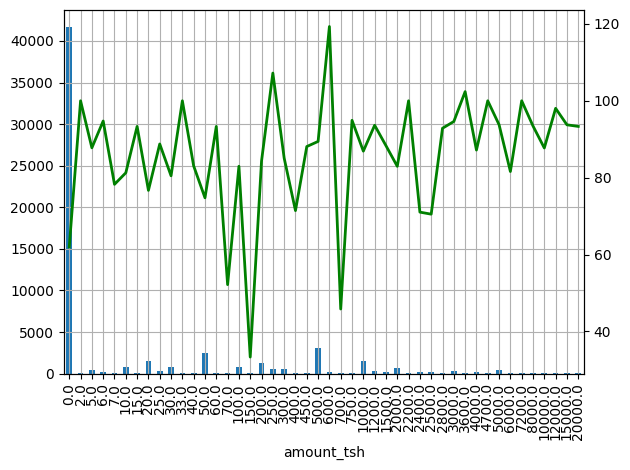

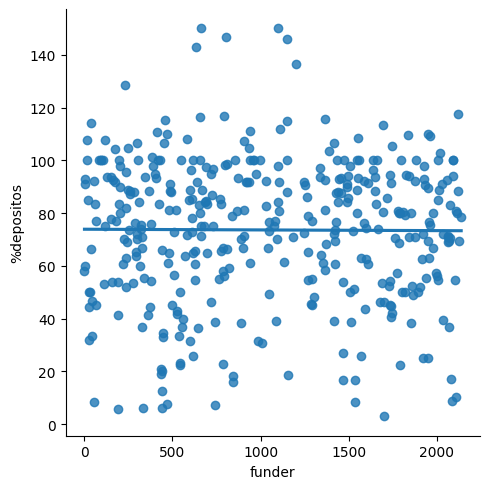

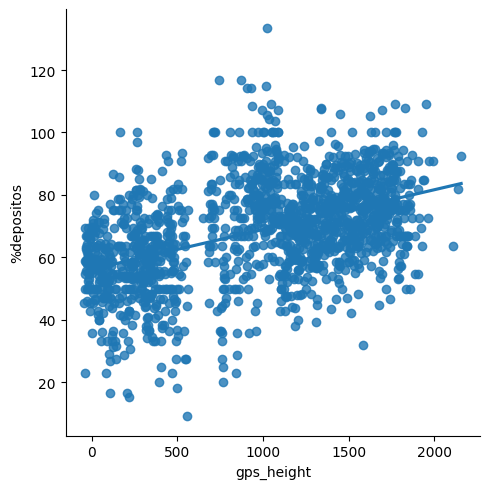

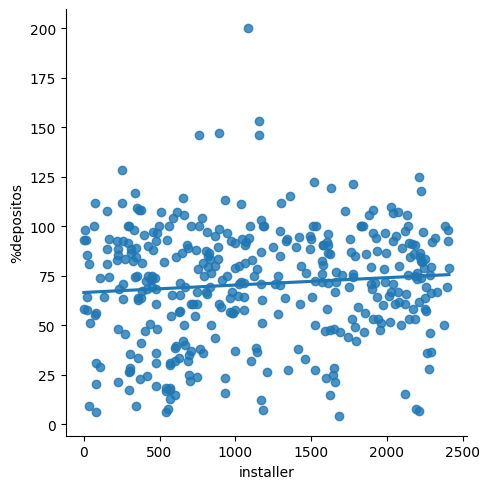

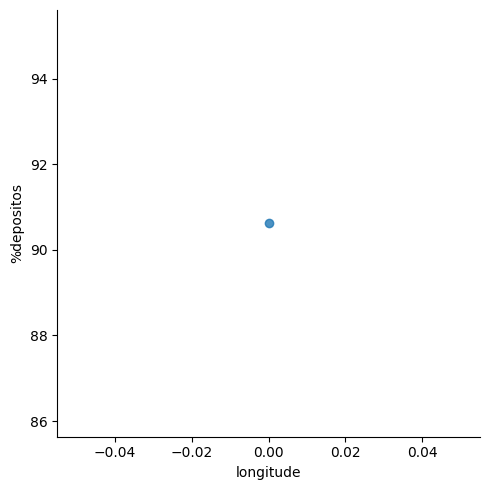

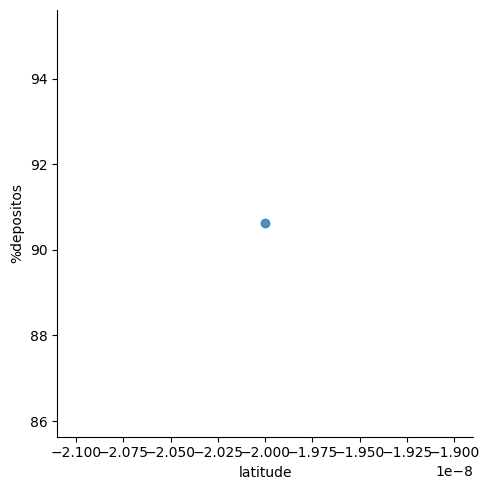

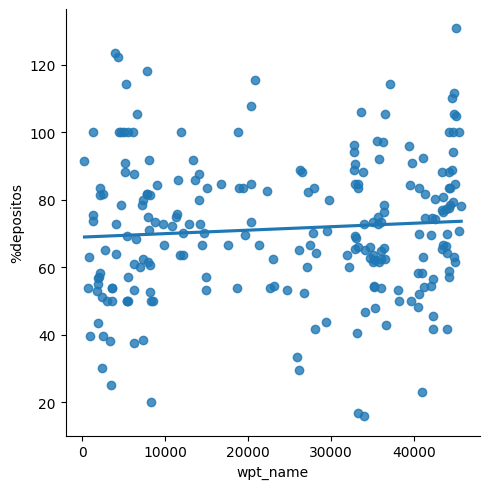

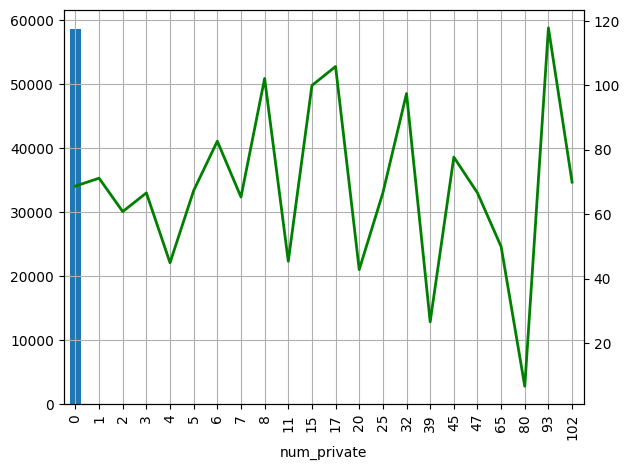

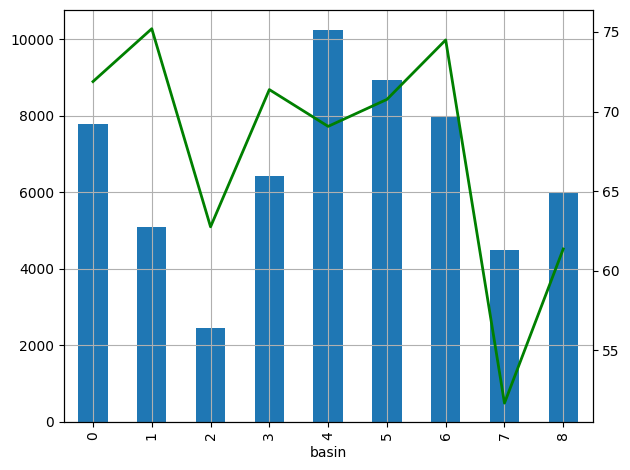

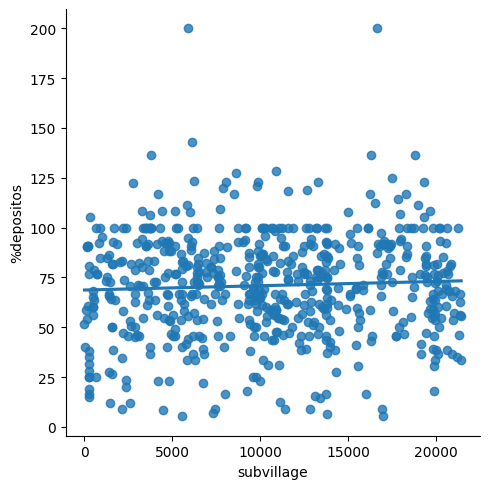

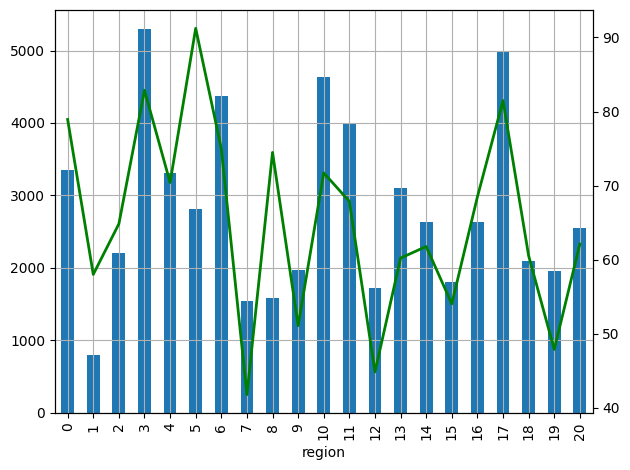

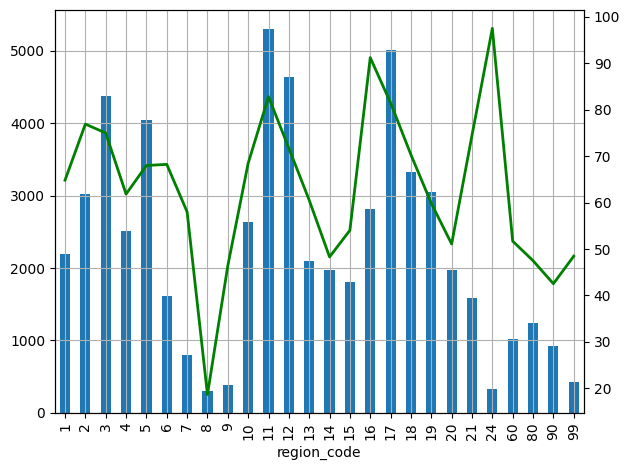

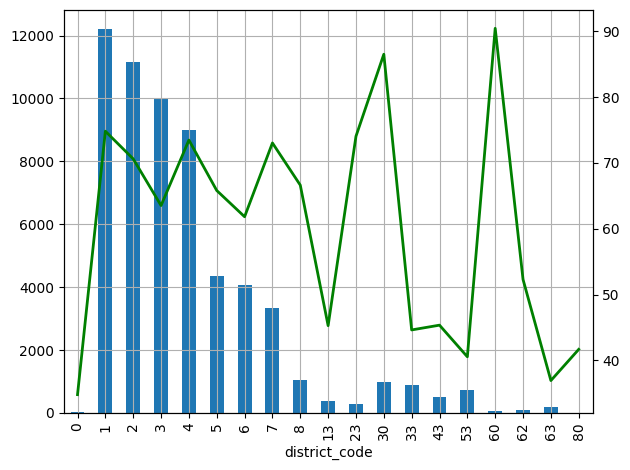

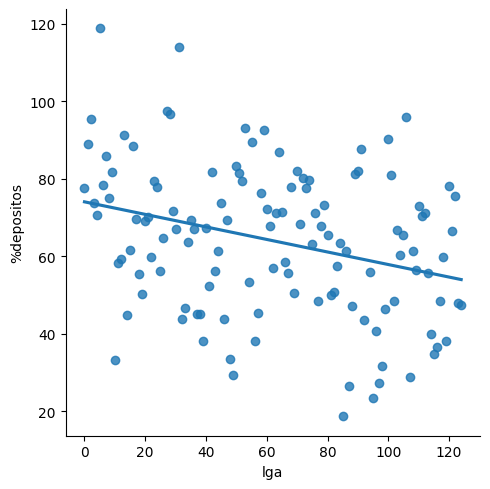

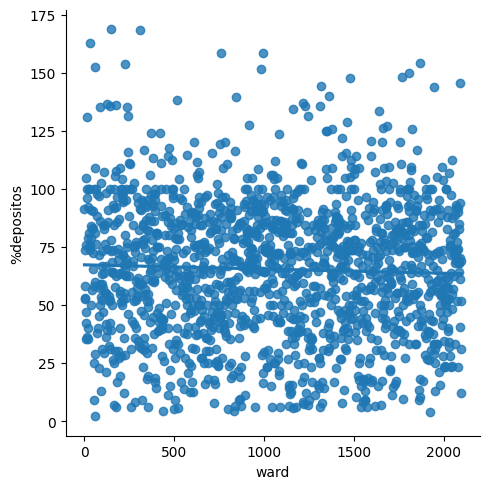

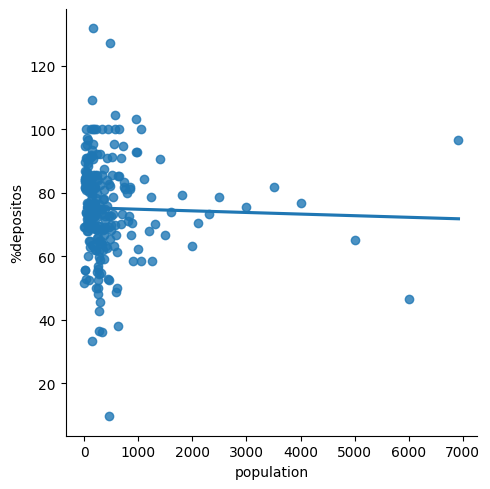

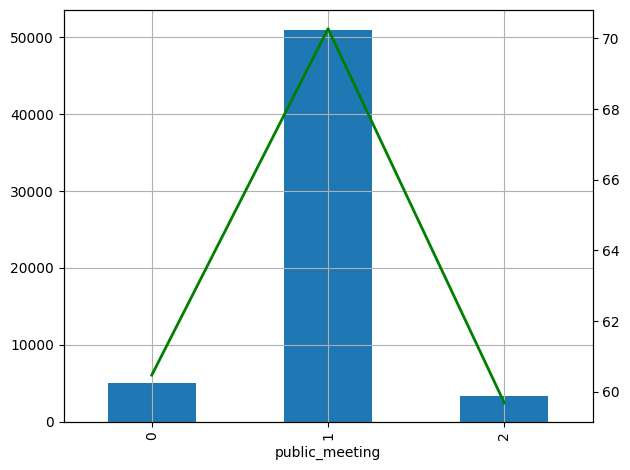

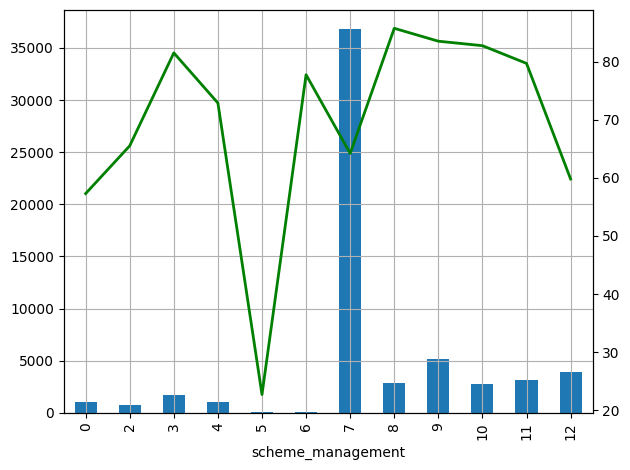

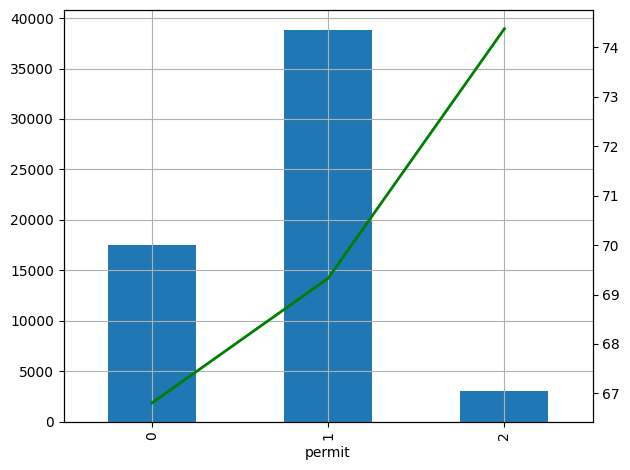

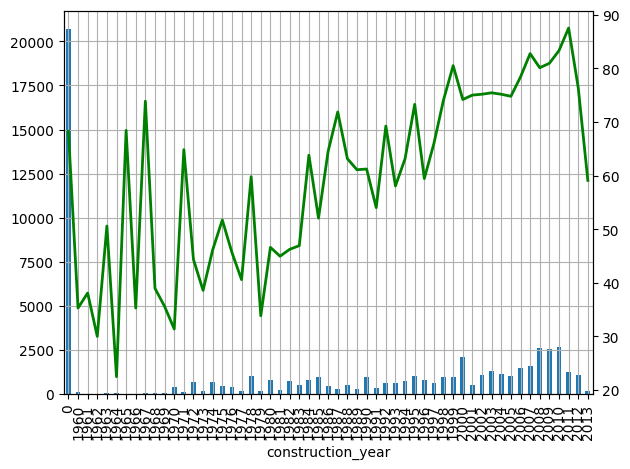

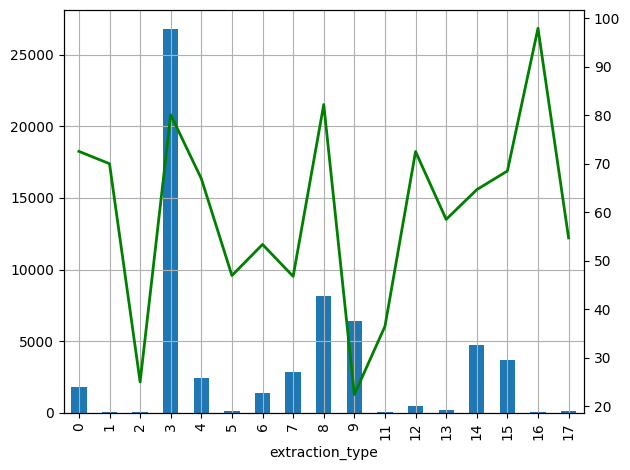

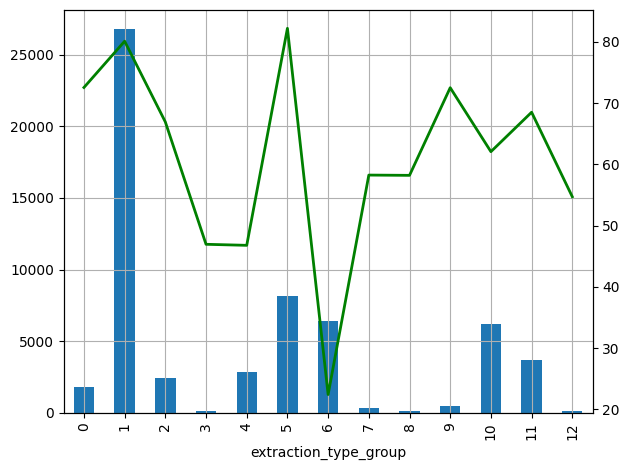

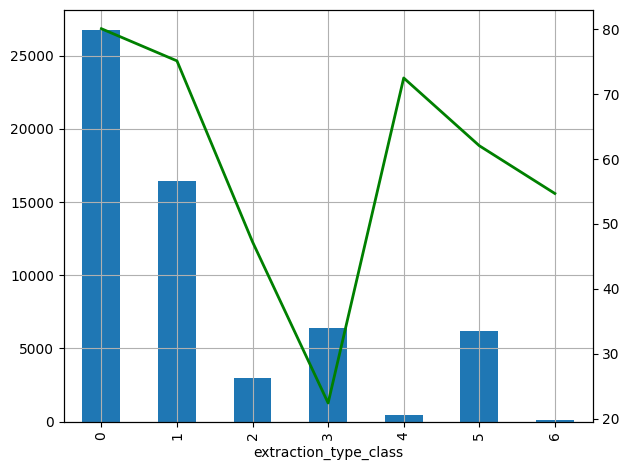

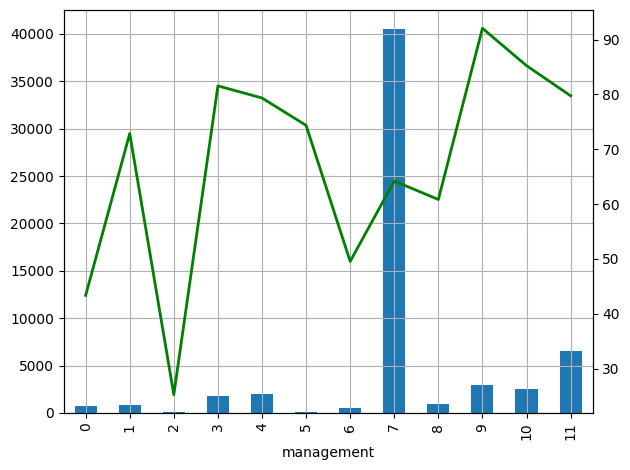

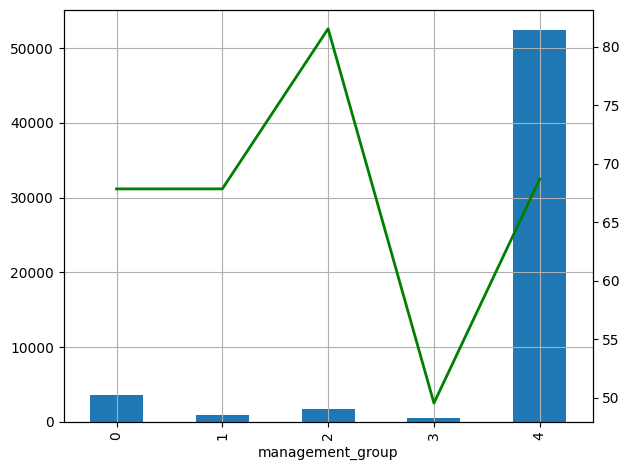

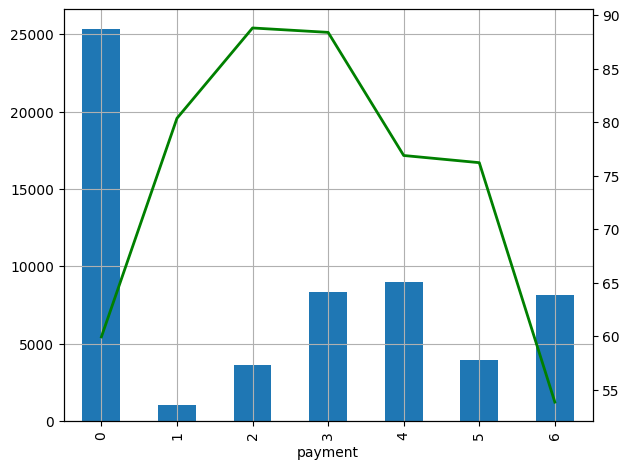

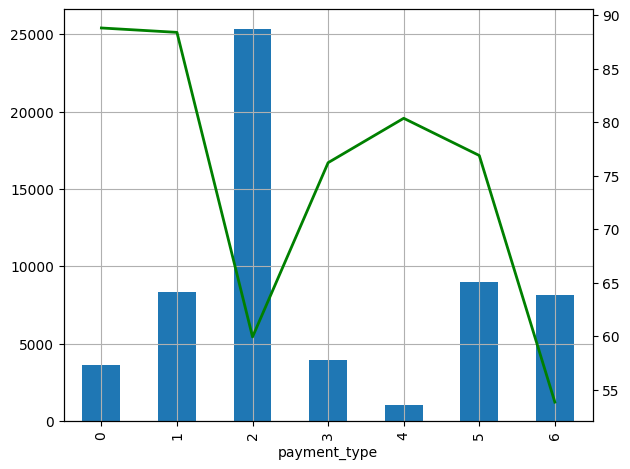

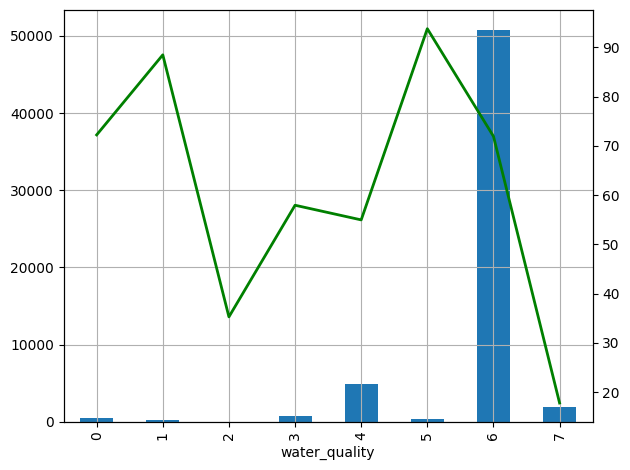

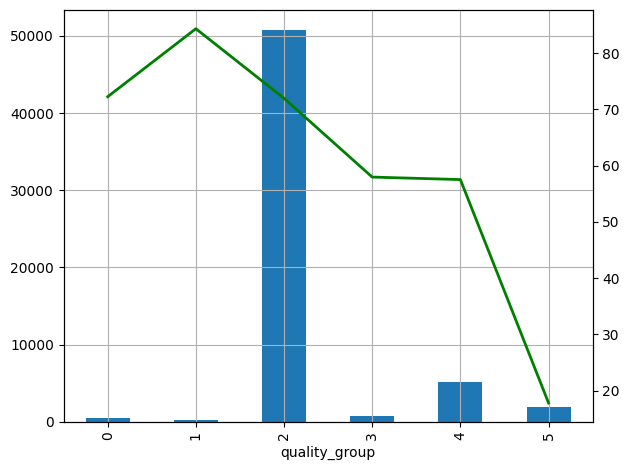

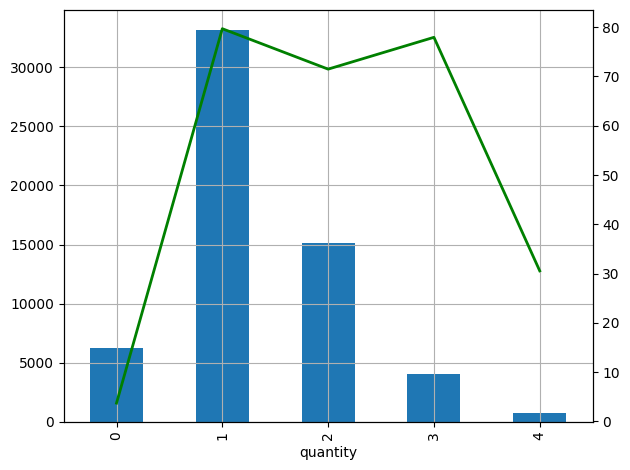

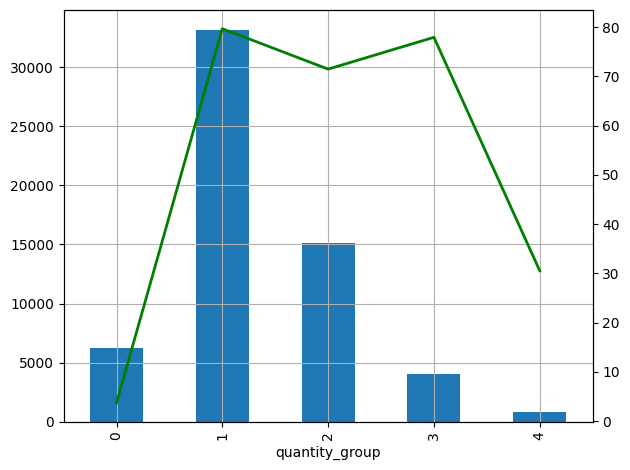

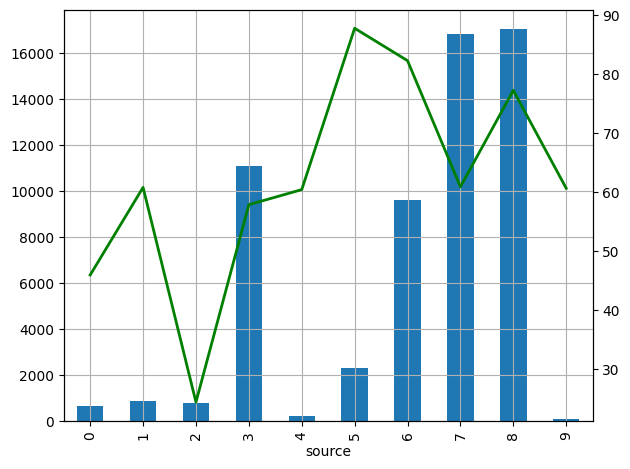

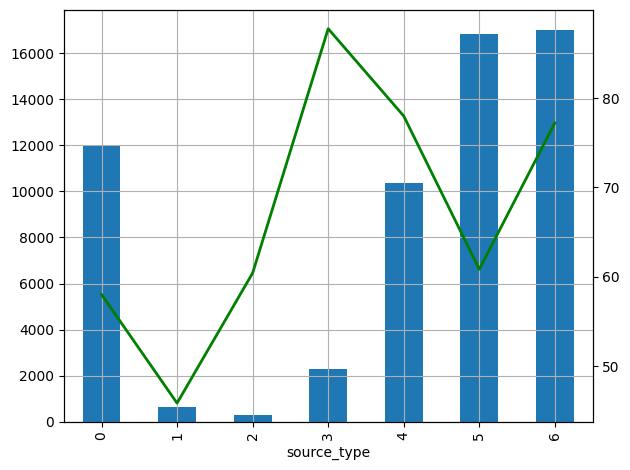

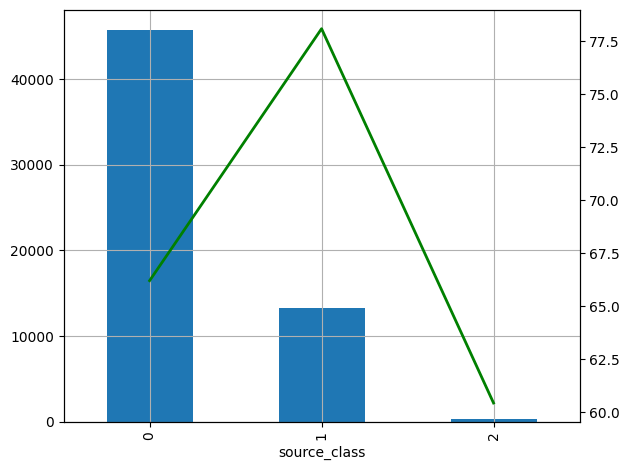

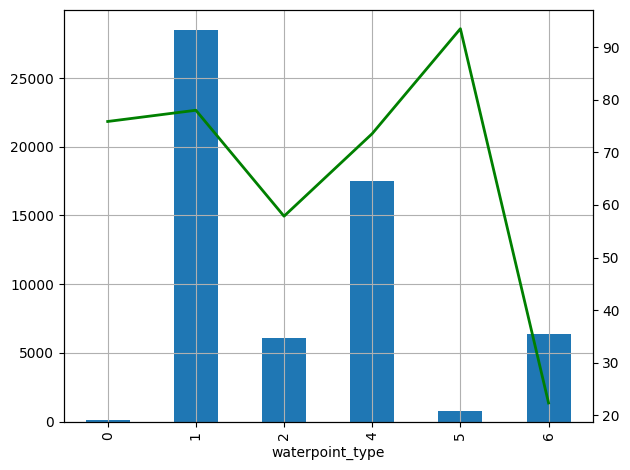

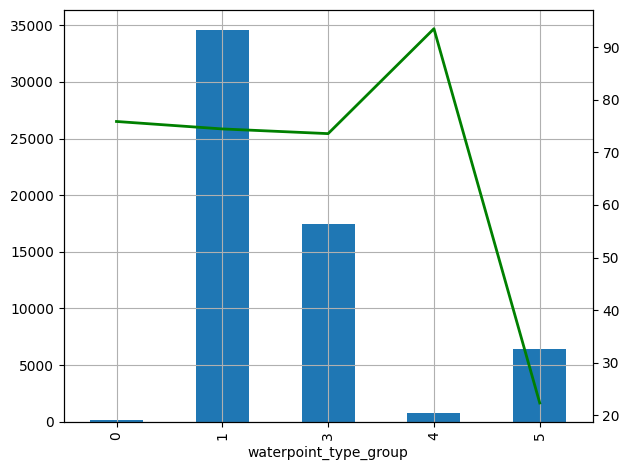

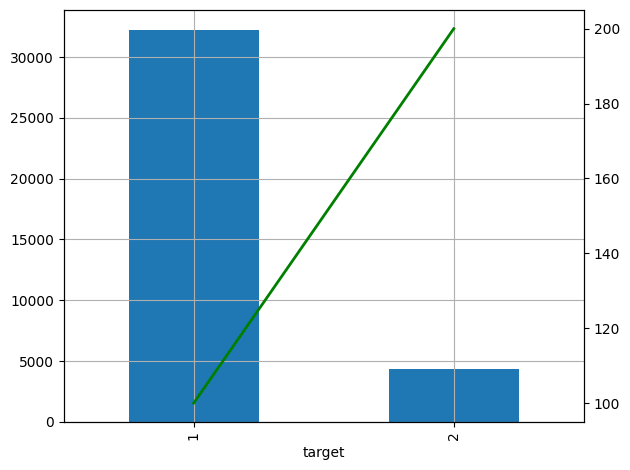

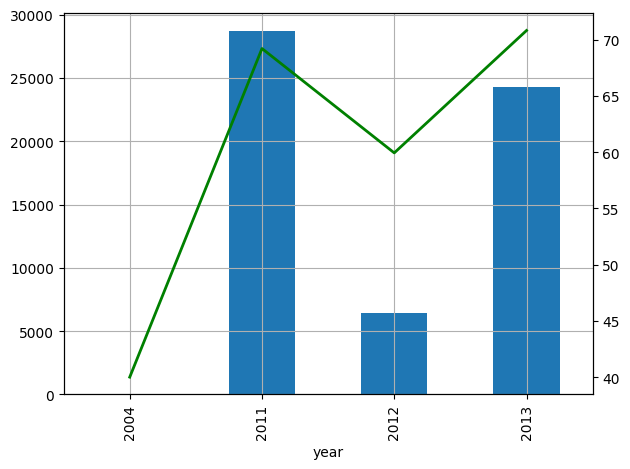

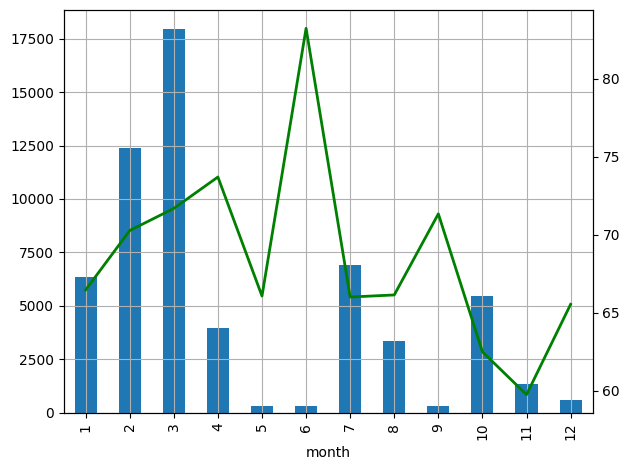

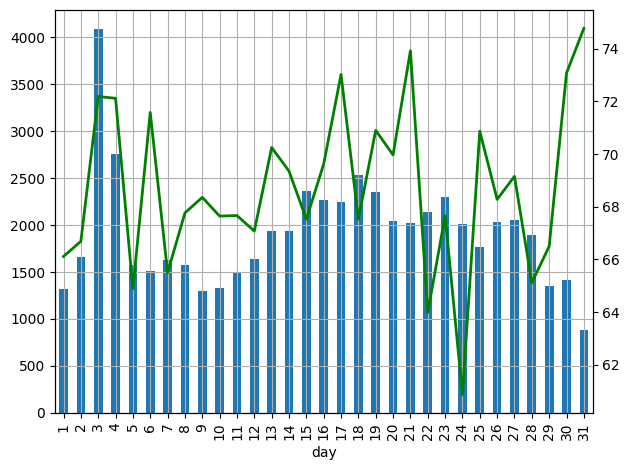

In [261]:
for i in water.columns:
    proporciones_final (i, 'target', water)

### <b> Tramificación de variables: </b>
* Después de ver que comportamiento tienen las variables frente a la variable objetivo podemos tramificar tanto gps_height como lga para darle más continuidad. 

In [262]:
dt["gps_height_new"] = dt["gps_height"].apply(lambda x: 0 if x<=600 else (2 if x>600 and x<1500 else(3))) 

dt["lga_new"] = dt["lga"].apply(lambda x: 0 if x<=40 else (2 if x>40 and x<81 else(3))) 


In [263]:
df_water = dt[dt["Conjunto"]=="train"]
df_test_water = dt[dt["Conjunto"]=="test"]
df_water.drop("Conjunto",axis=1,inplace=True);


In [264]:
df_test_water.drop(columns={"target","Conjunto"},inplace=True)

In [265]:
X_train, X_test, y_train, y_test = train_test_split(df_water.drop('target',axis=1),
                                                    df_water.target,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = df_water.target)

In [266]:
modelfinal = RandomForestClassifier().fit(X_train,y_train)
y_pred_final = modelfinal.predict(X_test)
print(classification_report(y_pred_final,y_test))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      4341
           1       0.89      0.82      0.85      6995
           2       0.35      0.55      0.43       544

    accuracy                           0.81     11880
   macro avg       0.68      0.74      0.70     11880
weighted avg       0.83      0.81      0.82     11880



In [267]:
resultado2 = modelfinal.predict(df_test_water)
prediccion2 = pd.DataFrame(resultado2,columns=["Predicciones"])
prediccion2["status_group"] = prediccion2["Predicciones"].map({1:"functional",0:"non functional",2:"functional needs repair"})
prediccion2=prediccion2.join(x_test.id)
entrega2=prediccion2.loc[:,['id','status_group']]
entrega2= entrega2.sort_index()
entrega2["status_group"] = entrega2["status_group"].astype('str')
entrega2["id"] = entrega2["id"].astype('str')
entrega2["id,status_group"]=(entrega2.id )+","+(entrega2.status_group)
entrega2.drop(columns={"status_group","id"},inplace=True)
entrega2=entrega2.set_index("id,status_group")
entrega2.to_csv('entrega_RF_Tramificada.csv',sep=";")

### <B>K-Best</b>
Seleccionamos las mejores variables y tiramos de nuevo el modelo.

In [268]:
selection = SelectKBest(k = 20)# instanciamos el modelo y selecciona 20 variables
feature_selection = selection.fit_transform(df_water, df_water['target'])

variables = list(np.asarray(list(df_water))[selection.get_support()])
variables.sort()
print(variables)

['extraction_type', 'extraction_type_class', 'extraction_type_group', 'gps_height', 'gps_height_new', 'lga', 'lga_new', 'longitude', 'payment_type', 'quality_group', 'quantity', 'quantity_group', 'region', 'region_code', 'source', 'source_class', 'source_type', 'target', 'waterpoint_type', 'waterpoint_type_group']


In [269]:
final_features= [
"extraction_type",
"extraction_type_class",
"extraction_type_group",
"gps_height",
"gps_height_new",
"lga",
"lga_new",
"longitude",
"payment_type",
"quality_group",
"quantity",
"quantity_group",
"region",
"region_code",
"source",
"source_class",
"source_type",
"waterpoint_type",
"waterpoint_type_group"
]

In [270]:
X_train, X_test, y_train, y_test = train_test_split(df_water[final_features],
                                                    df_water.target,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = df_water.target)

In [271]:
modelfinal = RandomForestClassifier().fit(X_train,y_train)
y_pred_final = modelfinal.predict(X_test)
print(classification_report(y_pred_final,y_test))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      4426
           1       0.84      0.80      0.82      6758
           2       0.34      0.43      0.38       696

    accuracy                           0.78     11880
   macro avg       0.65      0.67      0.66     11880
weighted avg       0.78      0.78      0.78     11880



Con la selección de variables no mejora nuestra puntuación.
Probamos a mandar los resultados para tener la última valoración.

In [272]:
df_test_water = df_test_water.loc[:,final_features]

In [273]:
resultado2 = modelfinal.predict(df_test_water)
prediccion2 = pd.DataFrame(resultado2,columns=["Predicciones"])
prediccion2["status_group"] = prediccion2["Predicciones"].map({1:"functional",0:"non functional",2:"functional needs repair"})
prediccion2=prediccion2.join(x_test.id)
entrega2=prediccion2.loc[:,['id','status_group']]
entrega2= entrega2.sort_index()
entrega2["status_group"] = entrega2["status_group"].astype('str')
entrega2["id"] = entrega2["id"].astype('str')
entrega2["id,status_group"]=(entrega2.id )+","+(entrega2.status_group)
entrega2.drop(columns={"status_group","id"},inplace=True)
entrega2=entrega2.set_index("id,status_group")
entrega2.to_csv('entrega_Kbest.csv',sep=";")


El entregable de K-Best no mejora el modelo por lo que nos quedamos con el RandomForest sin K-Best ni oversampling.

In [274]:
model1 = RandomForestClassifier().fit(water.drop('target',axis=1),water.target)
y_pred1 = model1.predict(test_water)

In [275]:
resultado2 = model1.predict(test_water)
prediccion2 = pd.DataFrame(resultado2,columns=["Predicciones"])
prediccion2["status_group"] = prediccion2["Predicciones"].map({1:"functional",0:"non functional",2:"functional needs repair"})
prediccion2=prediccion2.join(x_test.id)
entrega2=prediccion2.loc[:,['id','status_group']]
entrega2= entrega2.sort_index()
entrega2["status_group"] = entrega2["status_group"].astype('str')
entrega2["id"] = entrega2["id"].astype('str')
entrega2["id,status_group"]=(entrega2.id )+","+(entrega2.status_group)
entrega2.drop(columns={"status_group","id"},inplace=True)
entrega2=entrega2.set_index("id,status_group")
entrega2.to_csv('entrega_Final_RF.csv',sep=";")

Nos quedamos con el model1 de RandomForestClassifier con un 8,193 de score obtenido con el modelo entrenado con el conjunto de datos completo


 ------ Puesto Actual 1732 --------

 